# Import Libaries 

In [1]:
%cd /Users/typhaine/Documents/Doc_Gorilla/WhereIsMyMNIST/notebooks

/Users/typhaine/Documents/Doc_Gorilla/WhereIsMyMNIST/notebooks


In [2]:
import os
import imageio
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import pygame
from psychopy import visual, core, event, gui, data

from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST, MotionCloudNoise
import MotionClouds as mc

from main import init
args = init(filename='../data/2019-06-12') # pas de drop out!
args


pygame 2.0.1 (SDL 2.0.14, Python 3.7.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-12',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Load the data 

In [3]:
## Unit tests

#transforms.GaussianBlur(kernel_size = 1, sigma=(0.1, 2.0))
transform=transforms.Compose([
                               WhatShift(args,i_offset=0, j_offset=0),
                               WhatBackground(contrast = args.contrast,
                                              noise=0, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               transforms.Normalize((args.mean,), (args.std,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

data, label = next(iter(train_loader))
#%timeit data, label = next(iter(train_loader))
print(label.shape)
print(data.shape)

torch.Size([100])
torch.Size([100, 1, 128, 128])


# Functions: Add a maximum of 9 digits within random locations

In [4]:
def add(data):
    data = data.numpy().reshape(100,128,128)
    return np.array([numbers(data) for i in range(100)]).reshape(100,128,128)

In [5]:
def numbers(data):
    num = [
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(-50,-30)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(-50,-30)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(0,20)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(-50,-20)),
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(0,20)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(0,20))]
    np.random.shuffle(num)
    return np.max((num[0:random.randint(1,9)]),axis = 0)

In [6]:
def random_roll(data, x_shift, y_shift):
    return np.roll(np.roll(data, x_shift, axis = 0), y_shift, axis = 1)

shape (100, 128, 128)


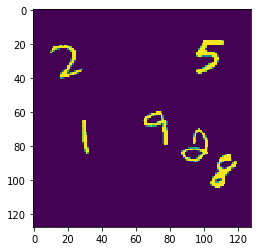

In [7]:
data = add(data)
print("shape", data.shape)
plt.imshow(data[0])

# Functions: Transform from 128x128x1 to 128x128x4 -RGBA

In [8]:
def RGBA(data):
    data = np.interp(data, (data.min(), data.max()), (0, 1))
    alpha = np.ones((data.shape[0],128,128))
    return np.stack((data,data,data,alpha),axis=-1)

Shape (100, 128, 128, 4)


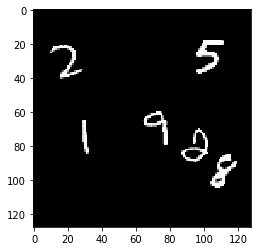

In [9]:
data = RGBA(data)
print("Shape", data.shape)
plt.imshow(data[0])

# Funcition: Add moving background

In [10]:
def motion(data,background):
    data = np.interp(data, (data.min(), data.max()), (0, 1))
    background = np.reshape(RGBA(background),(128,128,4))
    return np.swapaxes(
        np.moveaxis(
            np.array([[
                np.max((
                    np.roll(background,back,axis =(0,1)),data[D,:,:,:]),axis=0) 
                for back in range(60)] 
                for D in range(data.shape[0])]),(0,1,2,3,4),(0,1,4,3,2)),3,4)

# np.swapaxes(x,3,4)
#np.moveaxis(x,(0,1,2,3,4),(0,1,4,3,2))
            

Data shape: numbers, frames, rgba, size, size  (100, 60, 4, 128, 128)
Background shape (128, 128, 1)


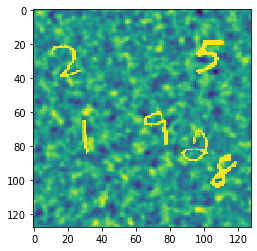

In [11]:
z, env = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf, alpha=.0, N_pic=128, seed=42, motion = True)
data = motion(data,np.moveaxis(z,(0,1,2),(2,1,0)))

print("Data shape: numbers, frames, rgba, size, size ", data.shape)
print("Background shape", z.shape)

#plt.imshow(np.moveaxis(z,(0,1,2),(2,1,0))[0])
plt.imshow(data[0,0,0,:,:])


# Function: digits phase out of moving background

In [12]:
def transparency(data):
    [[[np.put(img[frame,3,row,:],np.where(img[frame,0,row,:]>0.9),np.linspace(0, 1, num=60)[frame]) 
       for row in range(128)] 
      for frame in range(60)] for img in data]

Shape (100, 60, 4, 128, 128)


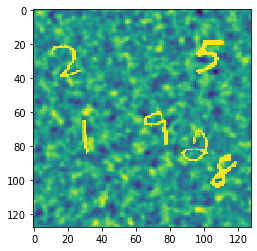

In [13]:
#%timeit transparency(data)
transparency(data)

print("Shape", data.shape)
plt.imshow(data[0,0,0,:,:])

# Random saccades 

In [14]:
def Random_Sac(Number_of_digits,Number_of_frames):
    return np.random.randint(0,128, size = (Number_of_digits,Number_of_frames,2)) # maybe (:,:,2)

saccades = Random_Sac(100,60)
print("Saccades: image, frame, [x,y]", saccades.shape)
saccades[0][0]

Saccades: image, frame, [x,y] (100, 60, 2)


array([28, 41])

# Psychopy to have a look at how it should run 

# Libaries

In [15]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Show image with landmark

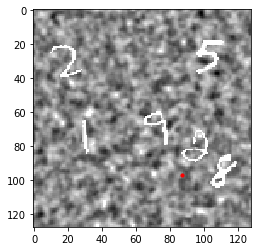

In [16]:
data = data.reshape(6000,4,128,128)
test = data[1]
test = np.moveaxis(test,(0,1,2),(2,0,1))


def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[0], landmarks[1], s=10, marker='o', c='r') 

plt.figure()
show_landmarks(test,saccades[1][1])
plt.show()

In [17]:
class LandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, image, landmarks, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks = landmarks
        self.image = image
        self.transform = transform

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #print("idx",self.image[idx])
        image = self.image[idx]
        #print("image",image)
        image = np.moveaxis(image,(0,1,2),(2,0,1))
        landmarks = self.landmarks[idx]
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (128, 128, 4) (60, 2)
1 (128, 128, 4) (60, 2)
2 (128, 128, 4) (60, 2)
3 (128, 128, 4) (60, 2)


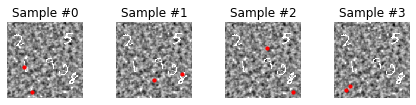

In [18]:
face_dataset = LandmarksDataset(data,saccades)


fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [ ]:
# You need to roll from the center 
# 

In [19]:
class RandomSaccadeTo(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        nb_sac = len(landmarks)
        #print(nb_sac)
        sac_num =  np.random.randint(nb_sac)
        #print(sac_num)
        sac = landmarks[sac_num]
        N_X, N_Y = image.shape[:1]
        #img_color_sac = saccade_to(image, (N_X//2, N_Y//2), (sac[1], sac[0]))
        image_roll = np.copy(image)
        #print("image_roll",image_roll.shape)
        #image_roll=np.roll(image_roll, N_X//2 - sac[1], axis=1)
        #image_roll=np.roll(image_roll, N_Y//2 - sac[0], axis=1)
        return {'image':image_roll, 'landmarks':sac}


0 (128, 128, 4) (60, 2)
1 (128, 128, 4) (60, 2)
2 (128, 128, 4) (60, 2)
3 (128, 128, 4) (60, 2)


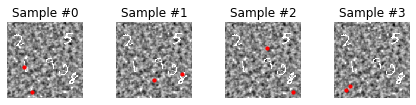

In [20]:
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

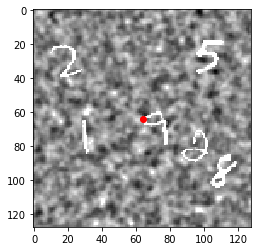

In [21]:
sample_sac = RandomSaccadeTo()(face_dataset[0])
plt.imshow(sample_sac['image'])
N_X, N_Y = sample_sac['image'].shape[:2]
plt.scatter(N_Y//2, N_X//2, c='r')

In [22]:
sample_sac

{'image': array([[[0.52769049, 0.52769049, 0.52769049, 1.        ],
         [0.53217863, 0.53217863, 0.53217863, 1.        ],
         [0.64218051, 0.64218051, 0.64218051, 1.        ],
         ...,
         [0.60612581, 0.60612581, 0.60612581, 1.        ],
         [0.54576522, 0.54576522, 0.54576522, 1.        ],
         [0.54606463, 0.54606463, 0.54606463, 1.        ]],
 
        [[0.53362881, 0.53362881, 0.53362881, 1.        ],
         [0.59878391, 0.59878391, 0.59878391, 1.        ],
         [0.74192768, 0.74192768, 0.74192768, 1.        ],
         ...,
         [0.52677386, 0.52677386, 0.52677386, 1.        ],
         [0.52774353, 0.52774353, 0.52774353, 1.        ],
         [0.52899758, 0.52899758, 0.52899758, 1.        ]],
 
        [[0.52246874, 0.52246874, 0.52246874, 1.        ],
         [0.63064141, 0.63064141, 0.63064141, 1.        ],
         [0.76697833, 0.76697833, 0.76697833, 1.        ],
         ...,
         [0.49105738, 0.49105738, 0.49105738, 1.        ],

In [23]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [24]:
transformed_dataset =  LandmarksDataset(data,saccades, transform=transforms.Compose([ToTensor()]))



for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 4:
        break

0 torch.Size([4, 128, 128]) torch.Size([60, 2])
1 torch.Size([4, 128, 128]) torch.Size([60, 2])
2 torch.Size([4, 128, 128]) torch.Size([60, 2])
3 torch.Size([4, 128, 128]) torch.Size([60, 2])
4 torch.Size([4, 128, 128]) torch.Size([60, 2])


In [25]:
%cd /Users/typhaine/Documents/Doc_Gorilla/POLO/dev
from PYramid2 import cropped_pyramid
class CroppedPyramid(object):
    def __init__(self, width, base_levels, color=True, do_mask=False, verbose=True):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
    
    def __call__(self, sample):
        #print(sample)
        img_crop, level_size = cropped_pyramid(sample['image'].unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True)
        return{'img_crop':img_crop, 'level_size':level_size, 'landmarks':sample['landmarks']}

/Users/typhaine/Documents/Doc_Gorilla/POLO/dev
Default lg shape= 32 32


In [26]:
width=32
base_levels=2
from LogGabor import LogGabor
from PYramid2 import local_filter
from PYramid2 import get_K
from PYramid2 import log_gabor_transform

In [27]:
n_sublevel = 2 
n_azimuth = 12 
n_theta = 12
n_phase = 2

pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg','jpeg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)
K = get_K(width=width,
            n_sublevel = n_sublevel, 
            n_azimuth = n_azimuth, 
                  n_theta = n_theta,
                  n_phase = n_phase, 
                  r_min = width/6, 
                  r_max = width/3, 
                  log_density_ratio = 2, 
                  verbose=False)

In [28]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=True, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose
    
    def __call__(self, sample):
        log_gabor_coeffs = log_gabor_transform(sample['img_crop'].unsqueeze(0), K)
        
        return{'img_gabor':log_gabor_coeffs, 'K':K}

In [29]:
#RandomSaccadeTo()
composed_transform = transforms.Compose([RandomSaccadeTo(),
                               ToTensor(),
                               CroppedPyramid(width, base_levels), LogGaborTransform()])

In [30]:
transformed_dataset =  LandmarksDataset(data,saccades, transform=composed_transform)

In [31]:
#pattern = 'i05june05_static_street_boston_p1010808'
#transformed_dataset['img_crop'].shape

In [32]:
test = transformed_dataset[1]
test["img_gabor"].shape

Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3


torch.Size([1, 3, 3, 2, 12, 12, 2])

In [33]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    for level in range(5,0,-1):
        plt.figure()
        images_batch = sample_batched['img_crop'][:,level,:,:,:]
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2

        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)).clip(0,255).astype('uint8'))

        plt.title('Batch from dataloader, level=' + str(level))

In [46]:
n_sublevel = 2 
n_azimuth = 12 
n_theta = 12
n_phase = 2
n_levels = 3 #int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
n_eccentricity = 2
n_color = 3

In [47]:
print(n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase)

5184


In [ ]:
# Here we need the input to be the image and then the output needs to be like x,y coordinates
# Encoder tranforms pixels into data 

# i = image 
# x,y = coordinates 
# Need to predict time + 1 i.e x,y at time + 1 
# You know time + 1, because it is the coordinates in the next frame 
# You could to try predict instead the next image 
# Change autoencoder 



# Variational Autoencoder - predict probability of x,y 

In [48]:
# distribution parameters  
#self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
#self.fc_var = nn.Linear(enc_out_dim, latent_dim)
#mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

class AutoEncoder(nn.Module):
    def __init__(self, in_chan = n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase, out_chan = 100):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(in_chan=in_chan, out_chan=out_chan)
        self.decoder = Decoder(in_chan=out_chan, out_chan=in_chan)

    def forward(self, x, **kargs): # x is the image () # def forward(self, x,sac, **kargs):
        code = self.encoder(x)
        out = self.decoder(code)
        return out

In [49]:
class Encoder(nn.Module):
    """ Encoder
    """
    def __init__(self, in_chan, out_chan): # Output of the decoder
        super(Encoder, self).__init__()
        self.enc = nn.Linear(in_chan, out_chan)
            
    def forward(self, x):
        return self.enc(x) 

In [50]:
# No decoder needed
class Decoder(nn.Module):
    """ Decoder
    """
    def __init__(self, in_chan, out_chan):
        super(Decoder, self).__init__()
        self.dec = nn.Linear(in_chan, out_chan) # output of the encoder
            
    def forward(self, x, sac): #def forward(self, x, sac):
        return self.dec(x)

In [51]:
autoenc = AutoEncoder()

In [52]:
autoenc.encoder.enc

Linear(in_features=5184, out_features=100, bias=True)

In [53]:
autoenc.encoder.enc.weight

Parameter containing:
tensor([[ 0.0016, -0.0057,  0.0118,  ..., -0.0021, -0.0053,  0.0119],
        [ 0.0061,  0.0027, -0.0119,  ...,  0.0004,  0.0023, -0.0015],
        [ 0.0018,  0.0064, -0.0038,  ...,  0.0031,  0.0014,  0.0118],
        ...,
        [ 0.0055,  0.0113,  0.0121,  ...,  0.0023, -0.0005,  0.0110],
        [ 0.0092,  0.0057,  0.0123,  ..., -0.0052,  0.0125, -0.0022],
        [-0.0051,  0.0049, -0.0005,  ...,  0.0027,  0.0121,  0.0048]],
       requires_grad=True)

In [54]:
autoenc.decoder.dec

Linear(in_features=100, out_features=5184, bias=True)

In [55]:
batch_size=1
n_epoch = 20
optimizer = optim.Adam(autoenc.parameters(), lr = 1e-4)
criterion = nn.MSELoss() #loss = criterion(outputs, inputs)

In [56]:
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [57]:
loss_list = []
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        #print(data)
    
        inputs = data['img_gabor'].view(-1, n_levels * n_color * n_eccentricity * n_azimuth * n_theta * n_phase) #complete la dim du batch, taille vecteurs (tenseurs->vecteurs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoenc(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if True:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            #.append
            loss_list.append(running_loss)
            running_loss = 0.0


Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,     1] loss: 0.151
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,     2] loss: 0.131
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,     3] loss: 0.140
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,     4] loss: 0.127
Tensor shape= torch.Size

[1,    37] loss: 0.122
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    38] loss: 0.138
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    39] loss: 0.110
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    40] loss: 0.128
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    41] loss: 0.113
T

[1,    72] loss: 0.121
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    73] loss: 0.105
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    74] loss: 0.114
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    75] loss: 0.097
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[1,    76] loss: 0.126
T

[2,     6] loss: 0.110
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,     7] loss: 0.105
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,     8] loss: 0.113
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,     9] loss: 0.111
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    10] loss: 0.121
T

[2,    41] loss: 0.128
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    42] loss: 0.113
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    43] loss: 0.101
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    44] loss: 0.099
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    45] loss: 0.101
T

[2,    75] loss: 0.117
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    76] loss: 0.101
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    77] loss: 0.125
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    78] loss: 0.093
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[2,    79] loss: 0.110
T

Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    10] loss: 0.100
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    11] loss: 0.098
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    12] loss: 0.112
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    13] loss: 0.091
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size

[3,    44] loss: 0.078
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    45] loss: 0.103
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    46] loss: 0.094
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    47] loss: 0.106
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    48] loss: 0.080
T

[3,    82] loss: 0.077
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    83] loss: 0.088
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    84] loss: 0.094
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    85] loss: 0.088
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[3,    86] loss: 0.106
T

Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    19] loss: 0.099
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    20] loss: 0.067
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    21] loss: 0.067
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    22] loss: 0.082
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size

Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    54] loss: 0.078
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    55] loss: 0.067
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    56] loss: 0.103
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    57] loss: 0.076
Tensor shape= torch.Size

Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    90] loss: 0.081
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    91] loss: 0.071
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    92] loss: 0.072
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[4,    93] loss: 0.061
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size

[5,    24] loss: 0.074
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    25] loss: 0.083
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    26] loss: 0.081
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    27] loss: 0.077
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    28] loss: 0.059
T

[5,    59] loss: 0.065
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    60] loss: 0.069
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    61] loss: 0.061
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    62] loss: 0.061
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    63] loss: 0.074
T

[5,    93] loss: 0.062
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    94] loss: 0.070
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    95] loss: 0.066
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    96] loss: 0.072
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[5,    97] loss: 0.059
T

[6,    28] loss: 0.064
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    29] loss: 0.075
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    30] loss: 0.059
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    31] loss: 0.063
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    32] loss: 0.085
T

[6,    62] loss: 0.060
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    63] loss: 0.070
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    64] loss: 0.063
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    65] loss: 0.064
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    66] loss: 0.069
T

[6,    96] loss: 0.067
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    97] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    98] loss: 0.062
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,    99] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[6,   100] loss: 0.056
T

[7,    31] loss: 0.069
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    32] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    33] loss: 0.056
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    34] loss: 0.069
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    35] loss: 0.064
T

Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    68] loss: 0.059
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    69] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    70] loss: 0.056
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[7,    71] loss: 0.053
Tensor shape= torch.Size

[8,     2] loss: 0.055
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,     3] loss: 0.062
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,     4] loss: 0.060
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,     5] loss: 0.077
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,     6] loss: 0.057
T

[8,    36] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    37] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    38] loss: 0.056
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    39] loss: 0.053
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    40] loss: 0.057
T

[8,    71] loss: 0.059
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    72] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    73] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    74] loss: 0.062
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[8,    75] loss: 0.055
T

[9,     6] loss: 0.048
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,     7] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,     8] loss: 0.049
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,     9] loss: 0.056
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    10] loss: 0.070
T

[9,    41] loss: 0.056
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    42] loss: 0.066
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    43] loss: 0.055
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    44] loss: 0.054
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    45] loss: 0.060
T

[9,    80] loss: 0.053
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    81] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    82] loss: 0.059
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    83] loss: 0.052
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[9,    84] loss: 0.062
T

[10,    18] loss: 0.046
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    19] loss: 0.049
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    20] loss: 0.048
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    21] loss: 0.050
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    22] loss: 0.

[10,    55] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    56] loss: 0.059
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    57] loss: 0.052
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    58] loss: 0.046
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    59] loss: 0.

[10,    92] loss: 0.046
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    93] loss: 0.067
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    94] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    95] loss: 0.053
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[10,    96] loss: 0.

[11,    29] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    30] loss: 0.045
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    31] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    32] loss: 0.048
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    33] loss: 0.

[11,    67] loss: 0.050
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    68] loss: 0.046
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    69] loss: 0.046
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    70] loss: 0.045
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[11,    71] loss: 0.

[12,     1] loss: 0.046
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,     2] loss: 0.045
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,     3] loss: 0.045
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,     4] loss: 0.044
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,     5] loss: 0.

[12,    36] loss: 0.039
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    37] loss: 0.038
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    38] loss: 0.053
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    39] loss: 0.044
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    40] loss: 0.

[12,    75] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    76] loss: 0.041
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    77] loss: 0.040
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    78] loss: 0.046
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[12,    79] loss: 0.

[13,    14] loss: 0.042
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    15] loss: 0.047
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    16] loss: 0.037
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    17] loss: 0.036
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    18] loss: 0.

[13,    50] loss: 0.053
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    51] loss: 0.040
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    52] loss: 0.056
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    53] loss: 0.053
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    54] loss: 0.

[13,    85] loss: 0.039
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    86] loss: 0.052
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    87] loss: 0.041
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    88] loss: 0.038
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[13,    89] loss: 0.

[14,    24] loss: 0.036
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    25] loss: 0.036
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    26] loss: 0.040
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    27] loss: 0.040
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    28] loss: 0.

[14,    64] loss: 0.054
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    65] loss: 0.036
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    66] loss: 0.033
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    67] loss: 0.036
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,    68] loss: 0.

[14,    99] loss: 0.034
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[14,   100] loss: 0.040
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,     1] loss: 0.055
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,     2] loss: 0.052
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,     3] loss: 0.

[15,    33] loss: 0.034
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    34] loss: 0.037
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    35] loss: 0.035
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    36] loss: 0.041
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    37] loss: 0.

[15,    68] loss: 0.049
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    69] loss: 0.033
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    70] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    71] loss: 0.033
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[15,    72] loss: 0.

[16,     2] loss: 0.034
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,     3] loss: 0.031
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,     4] loss: 0.052
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,     5] loss: 0.032
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,     6] loss: 0.

[16,    41] loss: 0.029
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    42] loss: 0.029
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    43] loss: 0.038
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    44] loss: 0.055
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    45] loss: 0.

[16,    76] loss: 0.032
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    77] loss: 0.033
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    78] loss: 0.037
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    79] loss: 0.035
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[16,    80] loss: 0.

[17,    12] loss: 0.030
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    13] loss: 0.030
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    14] loss: 0.028
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    15] loss: 0.035
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    16] loss: 0.

[17,    48] loss: 0.029
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    49] loss: 0.036
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    50] loss: 0.034
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    51] loss: 0.033
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    52] loss: 0.

[17,    82] loss: 0.059
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    83] loss: 0.034
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    84] loss: 0.035
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    85] loss: 0.038
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[17,    86] loss: 0.

[18,    18] loss: 0.030
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    19] loss: 0.026
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    20] loss: 0.034
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    21] loss: 0.029
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    22] loss: 0.

[18,    54] loss: 0.025
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    55] loss: 0.030
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    56] loss: 0.042
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    57] loss: 0.048
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    58] loss: 0.

[18,    90] loss: 0.035
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    91] loss: 0.029
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    92] loss: 0.042
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    93] loss: 0.027
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[18,    94] loss: 0.

[19,    24] loss: 0.026
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    25] loss: 0.051
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    26] loss: 0.025
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    27] loss: 0.024
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    28] loss: 0.

Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    64] loss: 0.031
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    65] loss: 0.029
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    66] loss: 0.026
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[19,    67] loss: 0.029
Tensor shape= torch.

[20,     1] loss: 0.053
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,     2] loss: 0.052
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,     3] loss: 0.049
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,     4] loss: 0.025
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,     5] loss: 0.

[20,    41] loss: 0.024
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    42] loss: 0.027
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    43] loss: 0.057
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    44] loss: 0.028
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    45] loss: 0.

[20,    75] loss: 0.025
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    76] loss: 0.025
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    77] loss: 0.026
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    78] loss: 0.025
Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])
Tensor shape= torch.Size([1, 4, 32, 32]) , shape= torch.Size([1, 4, 64, 64])
Top tensor shape= torch.Size([1, 4, 32, 32]) , Final n_levels= 3
[20,    79] loss: 0.